# CNN Exercise 2: Image Classification with CNNs - Solution

We will use the CIFAR10 dataset, which consists of 60000 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. In this exercise we will only use the dog and cat classes and we will train a CNN to distinguish between the two.

In the following cell we load the dataset again from ```torchvision.datasets```. There is a bunch of code that is not relevant for this exercise, but you can have a look at it if you are interested. The important part is that we load training and test data, only select the dog and cat classes, and do some augmentation and normalizing of the data.

Thanks to [this Gist](https://gist.github.com/Miladiouss/6ba0876f0e2b65d0178be7274f61ad2f) for the code to load the CIFAR10 dataset.

Created by Cedric Ewen in 2023


In [20]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

from torchsummary import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [21]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [22]:
# transformations
RC = transforms.RandomCrop(32, padding=4)
RHF = transforms.RandomHorizontalFlip()
NRM = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
TT = transforms.ToTensor()

# transforms object for trainset with augmentation
transform_with_aug = transforms.Compose([TT, RC, RHF, NRM])
# transforms object for testset w/o augmentation
transform_no_aug = transforms.Compose([TT, NRM])

# downloading/louding CIFAR10 data
trainset = CIFAR10(
    root='data',
    train=True,
    download=True,
    transform=transform_with_aug)
testset = CIFAR10(
    root='data',
    train=False,
    download=True,
    transform=transform_no_aug)
classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
             'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog',
           'horse', 'ship', 'truck']

# separating trainset/testset data/label
x_train = trainset.data
x_test = testset.data
y_train = np.array(trainset.targets)
y_test = np.array(testset.targets)

Files already downloaded and verified
Files already downloaded and verified


We now choose the classes we want to use for the classification. We start with cats and dogs and will later add more classes.

In [23]:
# This code block will remove all data samples that do not belong to
# class 'cat' or to class 'dog'.
classes = ['cat', 'dog']

# all classes of CIFAR-10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# initialize masks and map according to chosen classes
mask_train = np.zeros(len(y_train), dtype=bool)
mask_test = np.zeros(len(y_test), dtype=bool)
lable_map = {}
for i, class_name in enumerate(classes):
    mask_train = mask_train | (y_train == classDict[class_name])
    mask_test = mask_test | (y_test == classDict[class_name])
    lable_map[classDict[class_name]] = i

# select data
trainset.data = x_train[mask_train]
testset.data = x_test[mask_test]
trainset.targets = y_train[mask_train].tolist()
testset.targets = y_test[mask_test].tolist()

# make class labels continuous again
trainset.targets = [lable_map[e] for e in trainset.targets]
testset.targets = [lable_map[e] for e in testset.targets]

In [24]:
batch_size = 64

# create dataset loaders from trainset and testset
kwargs = {'num_workers': 4, 'pin_memory': False,
          'batch_size': batch_size}
trainloader = DataLoader(
    trainset, shuffle=True, **kwargs)
testloader = DataLoader(
    testset, shuffle=False, **kwargs)

We now have a training and test set of the selected classes that are one-hot-encoded. Let's look at some of the images.
- What's the size of the images?
- How many images do we have in training and test set?

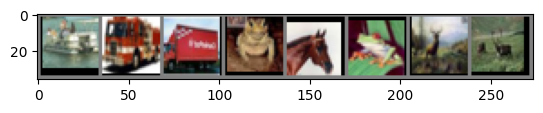

ship  truck truck frog  horse frog  deer  deer 


In [25]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)

images, labels = next(dataiter)

images_to_plot = 8

# show images
imshow(torchvision.utils.make_grid(images[:images_to_plot]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(images_to_plot)))

In [26]:
print('images shape:', 'x'.join(str(e) for e in images.shape[1:]))
print('length train dataset:', len(trainset))
print('length test dataset:', len(testset))

images shape: 3x32x32
length train dataset: 50000
length test dataset: 10000


# Define the Network
This is the only area you will need to change

In [27]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # define the layers
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=3,              
                out_channels=8,            
                kernel_size=3,              
                stride=1,                   
                padding="same",                  
            ),                             
            nn.ReLU(),                      
        )
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=8,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding="same",                  
            ),                              
            nn.ReLU(),                        
        )
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Sequential(         
            nn.Conv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=3,              
                stride=1,                   
                padding="same",                  
            ),                              
            nn.ReLU(),                        
        )
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.out = nn.Sequential(
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 2),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = x.view(x.size(0), -1)   
        output = self.out(x)
        return output

In [28]:
# Model for 10 class classification
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # define the layers
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=3,              
                out_channels=32,            
                kernel_size=3,              
                stride=1,                   
                padding="same",                  
            ),                             
            nn.ReLU(),                      
        )
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=32,              
                out_channels=64,            
                kernel_size=3,              
                stride=1,                   
                padding="same",                  
            ),                              
            nn.ReLU(),                        
        )
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Sequential(         
            nn.Conv2d(
                in_channels=64,              
                out_channels=128,            
                kernel_size=3,              
                stride=1,                   
                padding="same",                  
            ),                              
            nn.ReLU(),                        
        )
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Sequential(         
            nn.Conv2d(
                in_channels=128,              
                out_channels=128,            
                kernel_size=3,              
                stride=1,                   
                padding="same",                  
            ),                              
            nn.ReLU(),                        
        )
        self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.out = nn.Sequential(        
            nn.Dropout(0.1),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.pool4(x)
        x = x.view(x.size(0), -1)   
        output = self.out(x)
        return output

In [29]:
model = CNN()
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (pool4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (out): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=512, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [30]:
summary(model, (3, 32, 32), batch_size=batch_size, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 32, 32, 32]             896
              ReLU-2           [64, 32, 32, 32]               0
         AvgPool2d-3           [64, 32, 16, 16]               0
            Conv2d-4           [64, 64, 16, 16]          18,496
              ReLU-5           [64, 64, 16, 16]               0
         AvgPool2d-6             [64, 64, 8, 8]               0
            Conv2d-7            [64, 128, 8, 8]          73,856
              ReLU-8            [64, 128, 8, 8]               0
         AvgPool2d-9            [64, 128, 4, 4]               0
           Conv2d-10            [64, 128, 4, 4]         147,584
             ReLU-11            [64, 128, 4, 4]               0
        AvgPool2d-12            [64, 128, 2, 2]               0
          Dropout-13                  [64, 512]               0
           Linear-14                   

# Training

In [31]:
# Cross Entropy Loss already includes Softmax
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [32]:
# move model to GPU
model = model.to(device)

In [33]:
learning_rate = 0.003
optimizer = optim.Adam(model.parameters(), lr = learning_rate)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.003
    maximize: False
    weight_decay: 0
)

The training loop is the same as in the previous exercise. The only difference is that we have added a validation loop, where we evaluate the model on the validation set (in our case the test data). We additionally save the loss and accuracy for both the training and validation set in a list, so that we can plot them later. The accuracy is the fraction of correctly classified images.

In [34]:
def train(num_epochs, model, trainloader, testloader):
    
    train_losses = []
    train_accuracy = []
    
    val_losses = []
    val_accuracy = []
        
    # Train the model    
    for epoch in range(num_epochs):
        
        # training
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        for i, (images, labels) in enumerate(trainloader, 0):
            
            # move data to GPU
            images = images.to(device)
            labels = labels.to(device)
            
            # run model
            output = model(images)     
            # compute loss          
            loss = loss_func(output, labels)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()   
            
            # save metrics for ploting
            train_loss += loss.item()
            train_acc += (output.argmax(dim=1) == labels).float().mean().item()
            
        train_loss = train_loss / len(trainloader)
        train_acc = train_acc / len(trainloader)
        train_losses.append(train_loss)
        train_accuracy.append(train_acc)
        
        # validation 
        model.eval()
        with torch.no_grad():
            val_loss = 0.0  
            val_acc = 0.0
            for i, (images, labels) in enumerate(testloader, 0):  
                images = images.to(device)
                labels = labels.to(device)
                pred = model(images)
                v_loss = loss_func(pred, labels)
                val_loss += v_loss.item()
                val_acc += (pred.argmax(dim=1) == labels).float().mean().item()
                
            val_loss = val_loss / len(testloader)
            val_acc = val_acc / len(testloader)
            val_losses.append(val_loss)     
            val_accuracy.append(val_acc)   

        print(f"Epoch: {epoch+1}/{num_epochs} | loss: {train_loss} - acc: {train_acc} | val_loss: {val_loss} - val_acc: {val_acc}")
    
    print(f"Finished training after {num_epochs} epochs")
    print(f"Best validation accuracy: {max(val_accuracy)}")
    return train_losses, val_losses, train_accuracy, val_accuracy

num_epochs = 50
train_losses, val_losses, train_accuracy, val_accuracy = train(num_epochs, model, trainloader, testloader)

Epoch: 1/50 | loss: 1.7389662357242517 - acc: 0.3478061061381074 | val_loss: 1.3998875169997003 - val_acc: 0.4746218152866242
Epoch: 2/50 | loss: 1.40005635529223 - acc: 0.4914681905370844 | val_loss: 1.2876341179677635 - val_acc: 0.5328423566878981
Epoch: 3/50 | loss: 1.2409667349837321 - acc: 0.553009111253197 | val_loss: 1.150990055245199 - val_acc: 0.591062898089172
Epoch: 4/50 | loss: 1.123578714440241 - acc: 0.6041799872122762 | val_loss: 1.0104538384516528 - val_acc: 0.6399283439490446
Epoch: 5/50 | loss: 1.0239865734906453 - acc: 0.6407049232736572 | val_loss: 0.9576327531201065 - val_acc: 0.6689888535031847
Epoch: 6/50 | loss: 0.9594869902524192 - acc: 0.6648217710997443 | val_loss: 0.9624523672328633 - val_acc: 0.6605294585987261
Epoch: 7/50 | loss: 0.9039398632619692 - acc: 0.6837835677749361 | val_loss: 0.9367311300745436 - val_acc: 0.6689888535031847
Epoch: 8/50 | loss: 0.8659702056204267 - acc: 0.6984494884910486 | val_loss: 0.8091495549602873 - val_acc: 0.720441878980891

# Evaluation

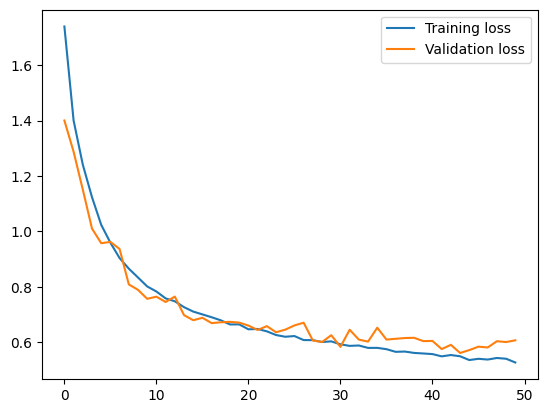

In [35]:
plt.plot(np.array(train_losses), label='Training loss')
plt.plot(np.array(val_losses), label='Validation loss')
plt.legend()
plt.show()

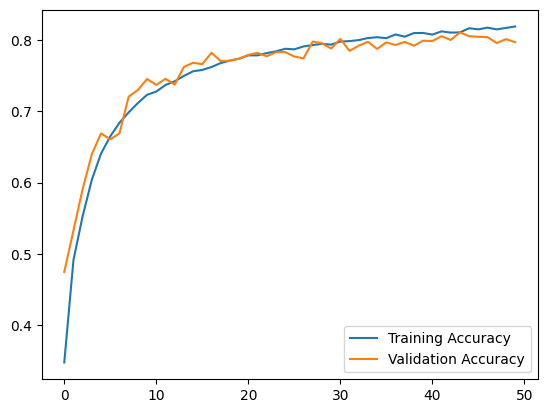

In [36]:
plt.plot(np.array(train_accuracy), label='Training Accuracy')
plt.plot(np.array(val_accuracy), label='Validation Accuracy')
plt.legend()
plt.show()

In the following, we will evaluate the last epoch on the test dataset and calculate the accuracy, look at some outputs and the confusion matrix.

In [37]:
# predicting labels for test data and calculating accuracy
correct = 0
total = 0
test_preds = []
test_labels = []
test_images = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        test_preds.append(predicted.cpu())
        test_labels.append(labels.cpu())
        test_images.append(images.cpu())
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()
    test_preds = torch.cat(test_preds).numpy()
    test_labels = torch.cat(test_labels).numpy()
    test_images = torch.cat(test_images)

print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 79 %


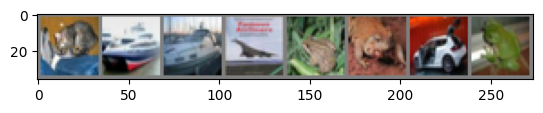

Truth:      cat   ship  ship  plane frog  frog  car   frog 
Predicted:  cat   ship  ship  ship  frog  frog  truck frog 


In [38]:
images_to_plot = 8

# show images
imshow(torchvision.utils.make_grid(test_images[:images_to_plot]))
# print labels
print('Truth:     ', ' '.join(f'{classes[test_labels[j]]:5s}' for j in range(images_to_plot)))
print('Predicted: ', ' '.join(f'{classes[test_preds[j]]:5s}' for j in range(images_to_plot)))

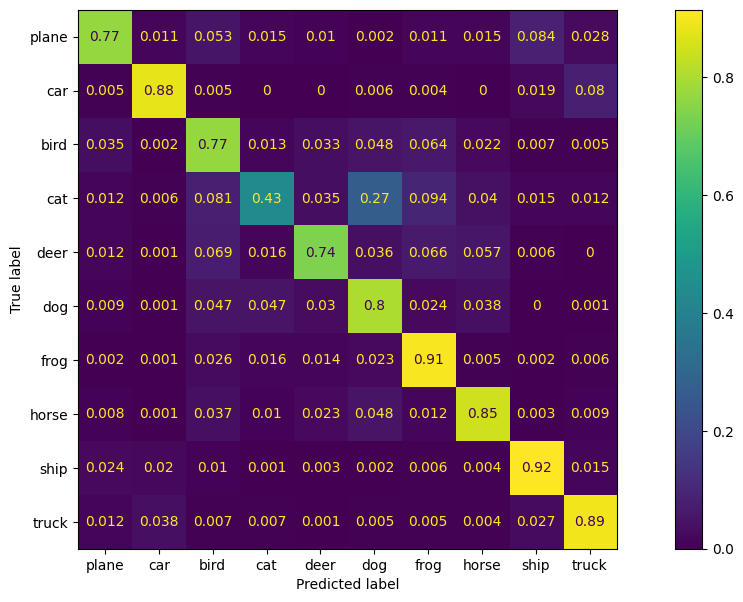

In [39]:
# Create confusion matrix and normalizes it over true labels
confusion = confusion_matrix(test_labels, test_preds, normalize='true')

# Create a plot of the confusion matrix
fig, ax = plt.subplots(figsize=(15, 7))
ConfusionMatrixDisplay(confusion, display_labels=classes).plot(ax=ax)
plt.show()

# Task

**Create a CNN that achieves a validation accuracy of at least 80%**

- Feel free to experiment on the network structure yourself. Use a combination of convolutional and pooling layers, similar to the first exercise.
- If your train and validation metrics diverge, you should consider including [Dropout layers](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html).

# Possible next steps

- A network with many parameters may perform better but a small network is trained faster and requires less computing resources. Can you reach the 70% validation accuracy in less than 20 epochs?
- The dataset does not only contain Cat and Dog pictures but 10 classes in total. You could rebuild the model as a multi-classifier. To achieve this, you would need to:
    - Include additional classes in your input. Do this by commenting out the one line of code in the data loading section.
    - What else do you need to change to make the model a multi-classifier?
    - Try to achieve the best validation accuracy you can. Which other parameters besides the architecture can you change to affect the performance?